In [1]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recover = pd.read_csv(url, error_bad_lines=False)

In [2]:
population=pd.read_csv('population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [3]:
# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[48:49,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,Population,region
48,NaN,Nigeria,9.082,8.6753,0,0,0,0,0,0,...,2,2,3,8,8,12,22,30,"204,630,242",Nigeria_nan


In [4]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [5]:
ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)

In [6]:
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)

Text(0.5, 1.0, 'Daily Total Confirmed - Nigeria')

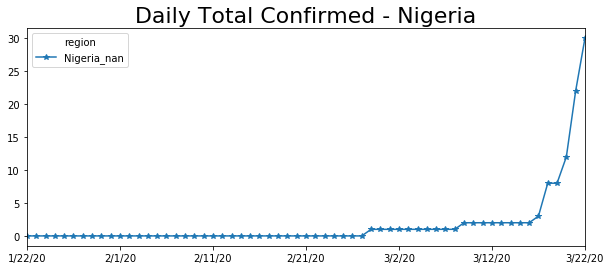

In [7]:
p.iloc[:,196:197].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Nigeria',fontdict={'fontsize': 22})

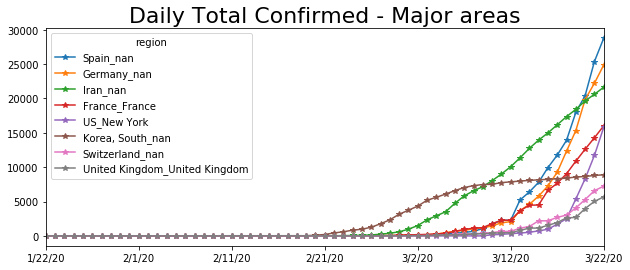

In [8]:
p.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Major areas',fontdict={'fontsize': 22})
p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)

Text(0.5, 1.0, 'Daily Total Death - Nigeria')

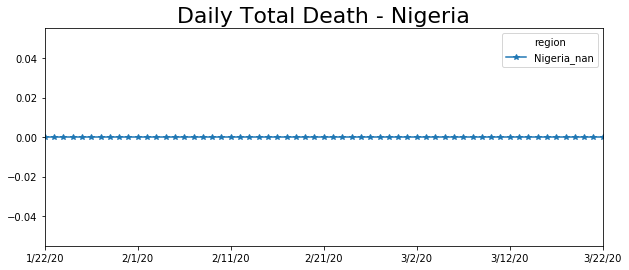

In [9]:
p_d.iloc[:,210:211].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Nigeria',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Death - Major areas')

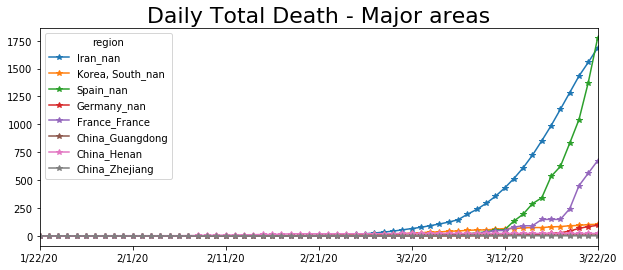

In [10]:
p_d.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Major areas',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Recoverd - Nigeria')

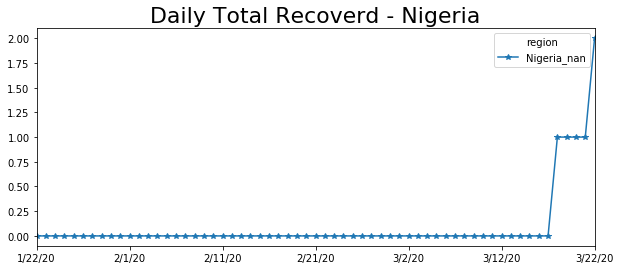

In [11]:
p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,210:211].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Nigeria',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Daily Total Recoverd - Major areas')

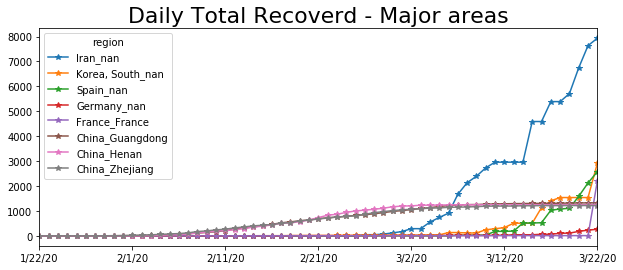

In [12]:
p_r.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Major areas',fontdict={'fontsize': 22})

In [16]:
# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'ts_r.csv')

In [18]:
import rpy2
%load_ext rpy2.ipython

In [19]:
%%R
install.packages('pracma')
install.packages('reshape')

In [21]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("ts_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]


Error in read_csv("ts_r.csv") : could not find function "read_csv"


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Will.000\\AppData\\Local\\Temp\\tmpd3_d7y8a\\Rplots001.png'